In [ ]:
import numpy as np
def F2(t,A,B,C,D):
  return A*(t**B)+C*np.cos(D*t)+np.random.normal(0,1,t.shape)

In [ ]:
n = 1000
T = np.random.normal((n,1))
b2 = F2(T,0.6,1.2,100,0.4)
def Energy(b2,T,A,B,C,D):
  return np.mean((b2-F2(T,A,B,C,D))**2)

y = np.zeros((1024,1))
for x in range(1024):
  d = -5.11+x/100
  y[x] = Energy(b2,T,0.6,1.2,100,d)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y)
plt.show()

In [ ]:
def gene2ABCD(gene):
  A = (np.sum(2**np.arange(10)*gene[0:10])-511)/100
  B = (np.sum(2**np.arange(10)*gene[10:20])-511)/100
  C = (np.sum(2**np.arange(10)*gene[20:30])-511)
  D = (np.sum(2**np.arange(10)*gene[30:40])-511)/100
  return A,B,C,D

pop = np.random.randint(0,2,(10000,40)) #人口數
fit = np.zeros((10000,1))  #基因組的適應度值
for generation in range(10): #共進行 10 代
  for i in range(10000):
    A,B,C,D = gene2ABCD(pop[i,:])
    fit[i] = Energy(b2,T,A,B,C,D)
  sortf = np.argsort(fit[:,0])
  pop = pop[sortf,:]  #根據適應度排序基因組，讓最優秀的基因組排在前面
  for i in range(1000,10000):  #交配過程
    fid = np.random.randint(0,1000)  #父親
    mid = np.random.randint(0,1000)  #母親
    while mid==fid:  #確保父母的DNA不重複
      mid = np.random.randint(0,1000)
    mask = np.random.randint(0,2,(1,40))  #隨機生成一個 40 位的mask，用來決定子代基因中每一位來自父親還是母親。
    son = pop[mid,:]  #創建一個新的子代，根據掩碼從父親或母親中選取基因。
    father = pop[fid,:]
    son[mask[0,:]==1] = father[mask[0,:]==1]
    pop[i,:] = son #產生新的子代

  for i in range(10000): #基因突變
    m = np.random.randint(1000,10000)
    n = np.random.randint(0,40)
    pop[m,n] = 1-pop[m,n]

In [ ]:
for i in range(10000):
  A,B,C,D = gene2ABCD(pop[i,:])
  fit[i] = Energy(b2,T,A,B,C,D)
sortf = np.argsort(fit[:,0])
pop = pop[sortf,:]

gene = pop[0,:]
A,B,C,D = gene2ABCD(gene)
print(A,B,C,D)

In [30]:
!pip install yfinance
!pip install pyswarm
!pip install deap
!pip install lmfit

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


[*********************100%***********************]  1 of 1 completed


開始優化...

最佳參數：
tc = 1238.16 (預測泡沫結束日期：2020-05-23)
beta = 0.5896
omega = 7.0000
phi = 3.5374
A = 671.5729
B = -7.4210
C = -0.1490
最佳MSE: 1342.2911


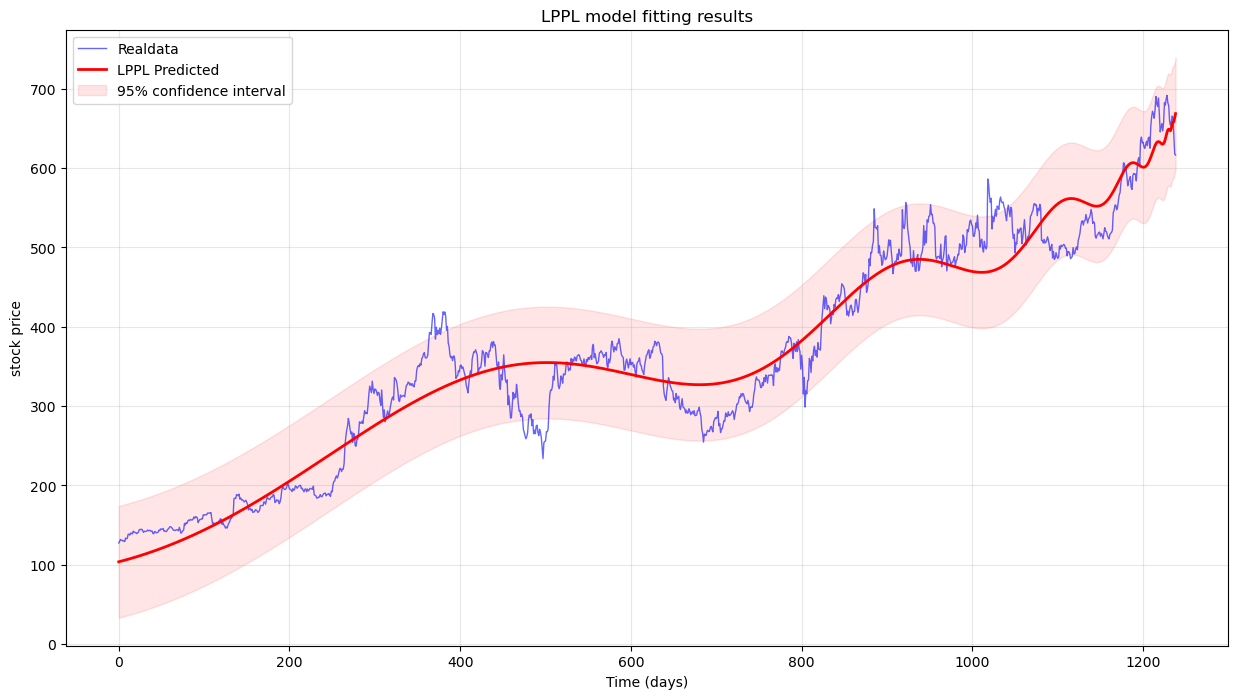

In [37]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, minimize
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

# 下載數據
nflx = yf.download('NFLX', start='2017-01-01', end='2022-10-31')
real_data = nflx['Adj Close'].values[:1239]
real_data = real_data.flatten()
t = np.arange(len(real_data))

# 添加數據預處理
def preprocess_data(data):
    # 使用移動平均來平滑數據
    window = 5
    smoothed_data = np.convolve(data, np.ones(window)/window, mode='valid')
    # 補齊長度
    padding = len(data) - len(smoothed_data)
    smoothed_data = np.pad(smoothed_data, (padding, 0), 'edge')
    return smoothed_data

smoothed_real_data = preprocess_data(real_data)

def lppl(t, tc, beta, omega, phi, A, B, C):
    dt = tc - t
    with np.errstate(divide='ignore', invalid='ignore'):
        dt = np.where(dt > 0, dt, np.nan)
        ln_dt = np.log(dt)
    model = A + B * dt**beta * (1 + C * np.cos(omega * ln_dt + phi))
    return model

# 自適應權重的目標函數
def objective(params):
    tc, beta, omega, phi, A, B, C = params

    if not check_constraints(params):
        return np.inf

    predicted = lppl(t, tc, beta, omega, phi, A, B, C)
    # 動態權重計算
    n = len(t)
    weights = np.exp(np.linspace(0, 2, n))  # 指數增長的權重
    weights = weights / np.sum(weights) * n  # 正規化

    # 計算基礎MSE
    valid_idx = ~np.isnan(predicted)
    mse = np.average((smoothed_real_data[valid_idx] - predicted[valid_idx])**2,
                     weights=weights[valid_idx])

    # 計算趨勢擬合度
    trend_mse = np.average((np.gradient(smoothed_real_data[valid_idx]) -
                           np.gradient(predicted[valid_idx]))**2)

    # 優化震盪控制
    oscillation_penalty = 0.01 * abs(C) * omega

    # 添加平滑度懲罰（使用二階導數）
    smoothness = np.sum(np.abs(np.gradient(np.gradient(predicted[valid_idx]))))
    smoothness_penalty = 0.001 * smoothness

    return mse + 0.3 * trend_mse + oscillation_penalty + smoothness_penalty

def check_constraints(params):
    tc, beta, omega, phi, A, B, C = params

    if tc <= t[-1] or tc > t[-1] + 50:  # 限制tc的預測範圍
        return False

    if not (0.1 <= beta <= 0.9):
        return False

    if not (6 <= omega <= 13):
        return False

    if abs(C) >= 1:
        return False

    if B >= 0:
        return False

    return True

# 改進3：增強型多階段優化
def enhanced_optimization(n_trials=50):
    best_score = np.inf
    best_params = None

    bounds = [
        (1201,1239),  # tc
        (0.2, 0.8),              # beta範圍
        (7, 12),                 # omega範圍
        (0, 2 * np.pi),          # phi
        (-5e3, 5e3),             # A的範圍
        (-5e3, 0),               # B的範圍
        (-0.8, 0.8)             # C的範圍
]

    for trial in range(n_trials):
        # 第一階段：粗略搜索
        result = differential_evolution(
          objective,
          bounds,
          strategy='best1bin',  
          maxiter=2000,         
          popsize=30,           
          mutation=(0.4, 0.9),  # 變異範圍
          recombination=0.8,    # 交叉概率0.7-0.9
          tol=1e-9,            # 提高精度要求
          seed=trial*100
      )

        # 第二階段：局部優化
        local_result = minimize(
          objective,
          result.x,
          method='L-BFGS-B',   
          bounds=bounds,
          options={
              'maxiter': 1500,
              'ftol': 1e-10,    # 提高精度
              'gtol': 1e-8      # 提高梯度收斂要求
          }
      )

        if local_result.fun < best_score:
            best_score = local_result.fun
            best_params = local_result.x

    # 第三階段：最終細化
    final_bounds = [(max(bound[0], param-abs(param)*0.05),
                    min(bound[1], param+abs(param)*0.05))
                   for bound, param in zip(bounds, best_params)]

    final_result = differential_evolution(
        objective,
        final_bounds,
        strategy='best1bin',
        maxiter=1000,
        popsize=20,
        tol=1e-9
    )

    if final_result.fun < best_score:
        best_score = final_result.fun
        best_params = final_result.x

    return best_params, best_score

# 執行優化
print("開始優化...")
best_params, best_score = enhanced_optimization(n_trials=50)
tc, beta, omega, phi, A, B, C = best_params

# 計算預測值
predicted_data = lppl(t, tc, beta, omega, phi, A, B, C)

# 輸出結果
print("\n最佳參數：")
print(f"tc = {tc:.2f} (預測泡沫結束日期：{(datetime(2017,1,1) + timedelta(days=int(tc))).strftime('%Y-%m-%d')})")
print(f"beta = {beta:.4f}")
print(f"omega = {omega:.4f}")
print(f"phi = {phi:.4f}")
print(f"A = {A:.4f}")
print(f"B = {B:.4f}")
print(f"C = {C:.4f}")
print(f"最佳MSE: {best_score:.4f}")

# 改進的可視化
plt.figure(figsize=(15, 8))
plt.plot(t, real_data, label="Realdata", color="blue", alpha=0.6, linewidth=1)
plt.plot(t, predicted_data, label="LPPL Predicted", color="red", linewidth=2)

# 計算動態置信區間
residuals = real_data - predicted_data[~np.isnan(predicted_data)]
std_dev = np.std(residuals)
plt.fill_between(t,
                predicted_data - 1.96*std_dev,
                predicted_data + 1.96*std_dev,
                color='red', alpha=0.1,
                label='95% confidence interval')

plt.xlabel("Time (days)")
plt.ylabel("stock price")
plt.title("LPPL model fitting results")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()